#### Thêm các thư viện cần thiết vào để scrape data

In [145]:
from bs4 import BeautifulSoup
import urllib.request
import requests
import pandas as pd
import numpy as np
import re

#### Sử dụng BeautifulSoup, Regex để xử lý, tách các dữ liệu cần thiết từ trang web

In [38]:
def download_html(url):
  with urllib.request.urlopen(url) as response:
    html = response.read()
    html = html.decode('utf-8')
  response.close()
  return html

In [39]:
url = "https://batdongsan.vn/ban-nha/"
html = download_html(url)
soup = BeautifulSoup(html, 'lxml')

#### Hàm phía dưới dung để tìm được số phòng ngủ, số phòng WC mà mỗi căn nhà có được, nếu không có giá trị sẽ mặc định là NaN value

In [40]:
def scrape_room(soup_link):
  text1=soup_link.find('div',class_='body').text.replace('\n','').replace('\t','').strip()
  text3=soup_link.find('div',class_='content').text.replace('\n','').replace('\r','').strip()
  try:
    so_PN=(re.search(r"(\d+)\s*PN", text1).group(1))
  except:
    try:
      so_PN=(re.search(r"(\d+)PN", text1).group(1))
    except:
      try:
        so_PN=(re.search(r"(\d+)\s*PN", text3).group(1))
      except:
        try:
          so_PN=(re.search(r"(\d+)PN", text3).group(1))
        except:
          so_PN=(np.nan)
  try:
    so_WC=(re.search(r"(\d+)\s*WC", text1).group(1))
  except:
    try:
      so_WC=(re.search(r"(\d+)WC", text1).group(1))
    except:
      try:
        so_WC=(re.search(r"(\d+)\s*WC", text3).group(1))
      except:
        try:
          so_WC=(re.search(r"(\d+)WC", text3).group(1))
        except:
          so_WC=(np.nan)
  return so_PN, so_WC

In [41]:
link = soup.find_all('div', {"class":"name"})
link_pos = link[4].find('a').get('href')
html_link = download_html(link_pos)
soup_link = BeautifulSoup(html_link, 'lxml')
scrape_room(soup_link)[0]

nan

#### Hàm phía dưới dùng để scrape 1 tin được đăng lên web

In [42]:
def scrape_block(house_block, pos):
  houseb_data = {}
  link = soup.find_all('div', {"class":"name"})
  link_pos = link[pos].find('a').get('href')
  html_link = download_html(link_pos)
  soup_link = BeautifulSoup(html_link, 'lxml')

  text1 = soup_link.find('div',{'class':'body'}).text.replace('\n','').replace('\t','').strip()
  text3 = soup_link.find('div',{'class':'content'}).text.replace('\n','').replace('\r','').strip()

  try:
    houseb_data['ID'] = int(soup_link.find_all('ul',{'class':"uk-list"})[6].find('span').contents[1].strip())
  except:
    houseb_data['ID'] = np.nan

  try:
    houseb_data['acreage'] = int(soup.find_all('span', {'class':"acreage"})[pos].contents[0].strip().replace("m",""))
  except:
    houseb_data['acreage'] = np.nan

  houseb_data['so_PN'] = scrape_room(soup_link)[0]

  houseb_data['so_WC'] = scrape_room(soup_link)[1]

  try:
    houseb_data['price'] = soup.find_all('span', {'class':"price"})[pos].contents[0].strip()
  except:
    houseb_data['price'] = np.nan

  try:
    text = soup_link.find('div', {"class":"content"}).get_text().strip()
    if "mặt tiền" in text:
      houseb_data['frontage'] = 1
    else:
      houseb_data['frontage'] = 0
  except:
    houseb_data['frontage'] = np.nan

  try:
    houseb_data['area'] = str(soup_link.find('ul',{'class':"uk-breadcrumb"}).find_all('a')[3].contents[0].strip())
  except:
    houseb_data['area'] = np.nan

  try:
    houseb_data['city'] = str(soup_link.find('ul',{'class':"uk-breadcrumb"}).find_all('a')[2].contents[0].strip())
  except:
    houseb_data['city'] = np.nan

  return houseb_data

#### Hàm scrape_house_page dùng để cào tất cả các tin ở trên 1 trang

In [43]:
def scrape_house_page(house_blocks):

  page_house_data = []
  num_blocks = len(house_blocks)

  for block in range(num_blocks - 5):
      page_house_data.append(scrape_block(house_blocks[block], block))

  return page_house_data

#### Chạy vòng lặp for để thu thập tất cả thông tin ở các trang kế tiếp
#### Vì một số trang không thể thu thập nên ta chạy trong khoảng 1 đến 900 cách nhau 4 trang

In [141]:
house_data = []
for i in range(1, 900, 4):
    base_url ="https://batdongsan.vn/ban-nha/"
    source = download_html(base_url + 'p' + str(i))
    soup = BeautifulSoup(source, 'html.parser')
    house_blocks = soup.find_all('div', {'class':"body"})
    house_data.extend(scrape_house_page(house_blocks))
house_data = pd.DataFrame(house_data)
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.0,NaN,NaN,Thỏa thuận,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.0,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
2,269451.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
3,269450.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
4,269449.0,NaN,NaN,NaN,Thỏa thuận,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.0,5,3,4.95 tỷ,0,Hoàng Mai,Hà Nội
2530,250237.0,50.0,NaN,NaN,7.5 tỷ,0,Đống Đa,Hà Nội
2531,250235.0,100.0,NaN,NaN,6 tỷ,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.0,3,2,3.48 tỷ,0,Quận 12,TP Hồ Chí Minh


#### Phía trên là data thu được

#### Chuyển data về file house_data.csv

In [142]:
house_data.to_csv("house_data.csv")

### Xử lý missing data bằng phương pháp MICE

#### Thêm vào các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
from fancyimpute import IterativeImputer

#### Đọc lại data từ file csv đã được lưu sau khi thu thập từ trang web

In [2]:
house_data = pd.read_csv('house_data.csv')

In [3]:
house_data

,Unnamed: 0,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,0,269453.0,37.0,NaN,NaN,Thỏa thuận,1,Bắc Từ Liêm,Hà Nội
1,1,269452.0,20.0,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
2,2,269451.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
3,3,269450.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
4,4,269449.0,NaN,NaN,NaN,Thỏa thuận,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...,...
2529,2529,250238.0,54.0,5.0,3.0,4.95 tỷ,0,Hoàng Mai,Hà Nội
2530,2530,250237.0,50.0,NaN,NaN,7.5 tỷ,0,Đống Đa,Hà Nội
2531,2531,250235.0,100.0,NaN,NaN,6 tỷ,0,Thủ Đức,TP Hồ Chí Minh
2532,2532,249841.0,52.0,3.0,2.0,3.48 tỷ,0,Quận 12,TP Hồ Chí Minh


#### Loại bỏ cột 'Unnamed: 0' vì không cần thiết 

In [4]:
house_data = house_data.drop(columns='Unnamed: 0')

In [5]:
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.0,NaN,NaN,Thỏa thuận,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.0,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
2,269451.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
3,269450.0,NaN,NaN,NaN,Thỏa thuận,0,Bắc Từ Liêm,Hà Nội
4,269449.0,NaN,NaN,NaN,Thỏa thuận,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.0,5.0,3.0,4.95 tỷ,0,Hoàng Mai,Hà Nội
2530,250237.0,50.0,NaN,NaN,7.5 tỷ,0,Đống Đa,Hà Nội
2531,250235.0,100.0,NaN,NaN,6 tỷ,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.0,3.0,2.0,3.48 tỷ,0,Quận 12,TP Hồ Chí Minh


#### Kiểm tra tần số bán nhà để xem các quận huyện nào có lượng nhà cần bán nhiều nhất

In [6]:
freq = house_data.groupby('area')['area'].agg('count').sort_values(ascending = False)
print(freq.to_string())

area
Gò Vấp                   203
Bình Tân                 168
Bình Thạnh               162
Tân Bình                 162
Thủ Đức                  121
Quận 7                   107
Tân Phú                  105
Hoàng Mai                 82
Biên Hòa                  80
Đống Đa                   76
Hai Bà Trưng              70
Cầu Giấy                  69
Thanh Xuân                67
Phú Nhuận                 64
Quận 10                   62
Hà Đông                   61
Quận 12                   51
Quận 9                    50
Long Biên                 49
Quận 8                    49
Tây Hồ                    41
Thanh Trì                 36
Hải Châu                  34
Huế                       33
Tân Uyên                  33
Thanh Khê                 32
Quận 3                    32
Hồng Bàng                 25
Ba Đình                   24
Nha Trang                 20
Hóc Môn                   19
Nam Từ Liêm               19
Quận 1                    17
Quận 4                    16
Quận 11  

#### kiểm tra tần số bán nhà để xem các tỉnh thành nào có lượng nhà cần bán nhiều nhất

In [7]:
fre = house_data.groupby('city')['city'].agg('count').sort_values(ascending = False)
print(fre.to_string())

city
TP Hồ Chí Minh     1438
Hà Nội              634
Đà Nẵng             114
Đồng Nai             94
Bình Dương           51
Hải Phòng            44
Thừa Thiên Huế       41
Khánh Hòa            21
Hậu Giang            15
Long An              13
Lâm Đồng             12
Tiền Giang           10
Bắc Ninh             10
Cần Thơ               5
An Giang              3
Kiên Giang            3
Bình Thuận            3
Bà Rịa Vũng Tàu       2
Ninh Thuận            2
Bến Tre               2
Yên Bái               2
Bình Phước            2
Lào Cai               2
Nam Định              1
Ninh Bình             1
Quảng Nam             1
Sóc Trăng             1
Cà Mau                1
Thanh Hóa             1
Đắk Lắk               1


In [8]:
house_data['price']

0       Thỏa thuận
1       Thỏa thuận
2       Thỏa thuận
3       Thỏa thuận
4       Thỏa thuận
           ...    
2529       4.95 tỷ
2530        7.5 tỷ
2531          6 tỷ
2532       3.48 tỷ
2533        1.1 tỷ
Name: price, Length: 2534, dtype: object

#### Nhận thấy ở cột price, các giá trị gồm nhiều thành phần như 'Thỏa thuận', 'tỷ', 'triệu', 'nghìn' nên ta xử lý để thành đơn vị 'tỷ'
#### Xem các giá trị 'Thỏa thuận' là các giá trị NaN

In [9]:
def convert_price(price):
    if 'Thỏa thuận' in price:
        price = np.nan
    elif 'nghìn' in price:
        price = float(price.replace('nghìn', ''))/1000
    elif 'triệu' in price:
        price = float(price.replace('triệu', ''))/1000000
    else:
        price = float(price.replace('tỷ', ''))
    return price

In [10]:
house_data.price = house_data.price.apply(lambda x: convert_price(x))

In [11]:
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.0,NaN,NaN,NaN,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.0,NaN,NaN,NaN,0,Bắc Từ Liêm,Hà Nội
2,269451.0,NaN,NaN,NaN,NaN,0,Bắc Từ Liêm,Hà Nội
3,269450.0,NaN,NaN,NaN,NaN,0,Bắc Từ Liêm,Hà Nội
4,269449.0,NaN,NaN,NaN,NaN,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.0,5.0,3.0,4.95,0,Hoàng Mai,Hà Nội
2530,250237.0,50.0,NaN,NaN,7.50,0,Đống Đa,Hà Nội
2531,250235.0,100.0,NaN,NaN,6.00,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.0,3.0,2.0,3.48,0,Quận 12,TP Hồ Chí Minh


#### Kiểm tra house_data

In [12]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        2530 non-null   float64
 1   acreage   2288 non-null   float64
 2   so_PN     1769 non-null   float64
 3   so_WC     1617 non-null   float64
 4   price     2278 non-null   float64
 5   frontage  2534 non-null   int64  
 6   area      2530 non-null   object 
 7   city      2530 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 158.5+ KB


#### Theo quan sát, các feature như 'ID', 'frontage', 'area' 'city' không nhận giá trị NaN hoặc NULL tại tất cả nên ta chỉ xét trên các cột còn lại

In [13]:
house_data_train = house_data.loc[:, ['acreage', 'so_PN', 'so_WC', 'price']]
house_data_train

,acreage,so_PN,so_WC,price
0,37.0,NaN,NaN,NaN
1,20.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
2529,54.0,5.0,3.0,4.95
2530,50.0,NaN,NaN,7.50
2531,100.0,NaN,NaN,6.00
2532,52.0,3.0,2.0,3.48


In [14]:
X_train = house_data_train.drop(columns = 'price')
y_train = house_data_train['price']

#### Sử dụng thư viện IterativeImputer để xử lý missing data

In [15]:
mice_imputer = IterativeImputer(random_state=100, max_iter = 10)
mice_imputer.fit(house_data_train)

IterativeImputer(random_state=100)

In [16]:
house_data_imputer = mice_imputer.transform(house_data_train)
house_data_imputer

array([[3.70000000e+01, 3.58285273e+00, 3.54162609e+00, 1.49414778e+08],
       [2.00000000e+01, 3.52142864e+00, 3.50260645e+00, 1.49414778e+08],
       [7.70041626e+01, 3.72739504e+00, 3.63344656e+00, 1.49414778e+08],
       ...,
       [1.00000000e+02, 3.81036887e+00, 3.68657166e+00, 6.00000000e+00],
       [5.20000000e+01, 3.00000000e+00, 2.00000000e+00, 3.48000000e+00],
       [6.00000000e+01, 1.00000000e+00, 1.00000000e+00, 1.10000000e+00]])

In [17]:
house_data.loc[:, ['acreage', 'so_PN', 'so_WC', 'price']] = house_data_imputer

#### Data thu được sau khi xử lý MICE

In [18]:
house_data

,ID,acreage,so_PN,so_WC,price,frontage,area,city
0,269453.0,37.000000,3.582853,3.541626,1.494148e+08,1,Bắc Từ Liêm,Hà Nội
1,269452.0,20.000000,3.521429,3.502606,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
2,269451.0,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
3,269450.0,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
4,269449.0,77.004163,3.727395,3.633447,1.494148e+08,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...,...
2529,250238.0,54.000000,5.000000,3.000000,4.950000e+00,0,Hoàng Mai,Hà Nội
2530,250237.0,50.000000,3.629710,3.571808,7.500000e+00,0,Đống Đa,Hà Nội
2531,250235.0,100.000000,3.810369,3.686572,6.000000e+00,0,Thủ Đức,TP Hồ Chí Minh
2532,249841.0,52.000000,3.000000,2.000000,3.480000e+00,0,Quận 12,TP Hồ Chí Minh


#### Chuyển data sau khi xử lý vào file csv

In [ ]:
house_data.to_csv('house_final.csv')

In [2]:
import pandas as pd
import numpy as np
df=pd.read_csv("house_final2.csv")

In [23]:
df

,acreage,so_PN,so_WC,price,frontage,area,city
0,37.000000,3.582853,3.541626,1.494148e+08,1,Bắc Từ Liêm,Hà Nội
1,20.000000,3.521429,3.502606,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
2,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
3,77.004163,3.727395,3.633447,1.494148e+08,0,Bắc Từ Liêm,Hà Nội
4,77.004163,3.727395,3.633447,1.494148e+08,0,Nam Từ Liêm,Hà Nội
...,...,...,...,...,...,...,...
2529,54.000000,5.000000,3.000000,4.950000e+00,0,Hoàng Mai,Hà Nội
2530,50.000000,3.629710,3.571808,7.500000e+00,0,Đống Đa,Hà Nội
2531,100.000000,3.810369,3.686572,6.000000e+00,0,Thủ Đức,TP Hồ Chí Minh
2532,52.000000,3.000000,2.000000,3.480000e+00,0,Quận 12,TP Hồ Chí Minh


<AxesSubplot: >

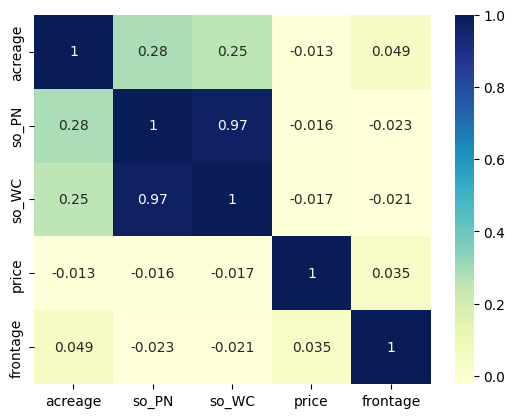

In [24]:
sns.heatmap(df.corr(),annot=True, cmap="YlGnBu")